In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

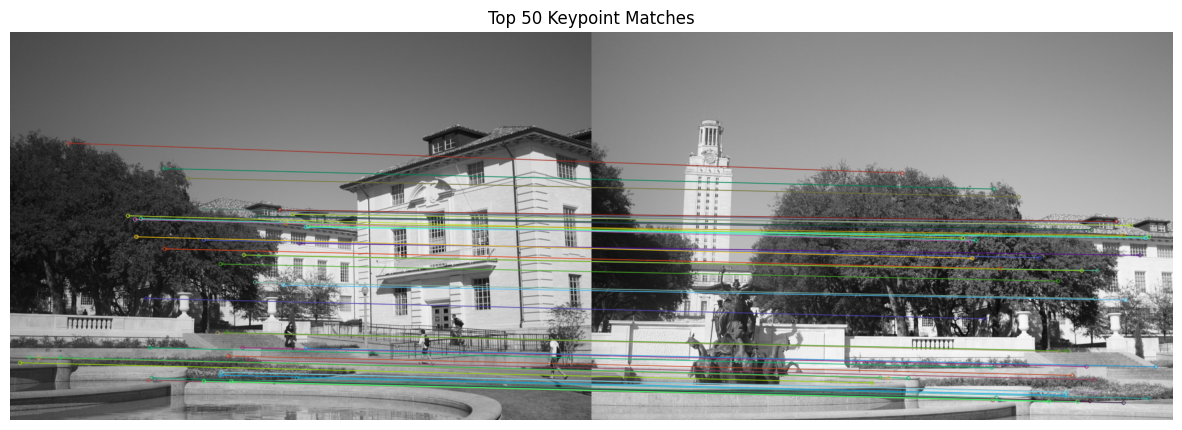

In [32]:
# Load the two images (both should be in grayscale for SIFT)
pano_img1 = cv2.imread('pano_image1.jpg', cv2.IMREAD_GRAYSCALE)
pano_img2 = cv2.imread('pano_image2.jpg', cv2.IMREAD_GRAYSCALE)

def match_keypoints_and_show(pano_img1, pano_img2, top_n_matches=50):
    # Check if images loaded properly
    if pano_img1 is None or pano_img2 is None:
        raise ValueError("Error: One or both images could not be loaded. Check the file paths.")
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(pano_img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(pano_img2, None)

    # Brute force matcher takes every descriptor in img and compares it to every descriptor in the other img
    # and returns the best match
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)  # k=2 means it will return the 2 best matches for each descriptor

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if (m.distance / n.distance) < 0.5:
            good_matches.append(m)

    # Take the top `top_n_matches` good matches
    good_matches = sorted(good_matches, key=lambda x: x.distance)[:top_n_matches]

    # Draw the matches
    matched_img = cv2.drawMatches(pano_img1, keypoints1, pano_img2, keypoints2, good_matches, None, flags=2)

    # Show the result
    plt.figure(figsize=(15, 10))
    plt.imshow(matched_img, cmap='gray')
    plt.title(f"Top {top_n_matches} Keypoint Matches")
    plt.axis('off')
    plt.show()

    # Return the good matches
    return good_matches,keypoints1,keypoints2


good_matches,keypoints1,keypoints2 = match_keypoints_and_show(pano_img1, pano_img2)


In [33]:
def compute_homography(src_pts, dst_pts):
    
    #src_pts: List or array of (x, y) points in the first image
    #dst_pts: Corresponding list or array of (x', y') points in the second image

    if len(src_pts) < 4:
        raise ValueError("Need at least 4 point correspondences.")

    A = []
    for (x, y), (x_prime, y_prime) in zip(src_pts, dst_pts):
        A.append([x, y, 1, 0, 0, 0, -x * x_prime, -y * x_prime])
        A.append([0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime])

    A = np.array(A)
    b = np.array(dst_pts).reshape(-1)# Flatten the dst_pts array to make it a 1D array
    # Solve Ah = b
    h = np.linalg.lstsq(A, b, rcond=None)[0]# Get the least-squares solution
    #print("Homography coefficients:", h)

    H = np.append(h, 1).reshape((3, 3))#make h33 = 1 and reshape it to 3x3 matrix
    return H

def compute_homography_ransac(src_pts, dst_pts, threshold=5, max_iter=100):
  
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    num_points = len(src_pts)
    best_H = None
    best_inliers = []
    max_inliers = 0

    for _ in range(max_iter):
        #Randomly choose 4 correspondences
        idxs = np.random.choice(num_points, 4, replace=False)
        src_sample = src_pts[idxs]
        dst_sample = dst_pts[idxs]

        #Compute homography from the 4 points
        H = compute_homography(src_sample, dst_sample)

        #Apply H to all src_pts
        src_hom = np.hstack([src_pts, np.ones((num_points, 1))])  # convert to homogeneous coordinates [x y 1]
        proj = (H @ src_hom.T).T 
        proj /= proj[:, 2][:, np.newaxis]  #convert back to hetergeneous coordinates

        #Compute reprojection error
        error = np.linalg.norm(proj[:, :2] - dst_pts, axis=1)

        #Count inliers
        inliers = error < threshold
        num_inliers = np.sum(inliers)

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inliers = inliers

    #recompute H using all inliers
    if max_inliers >= 4:
        best_H = compute_homography(src_pts[best_inliers], dst_pts[best_inliers])
    else:
        raise ValueError("Not enough inliers found.")

    return best_H, best_inliers

def apply_homography(H, points):
    #Apply the homography matrix to the points.

    points_hom = np.hstack([points, np.ones((len(points), 1))])  # Convert to homogeneous coordinates [x y 1]
    transformed = (H @ points_hom.T).T  # Matrix multiplication to apply the homography

    # Convert back to Cartesian coordinates(2D) by dividing by the last coordinate
    transformed /= transformed[:, 2][:, np.newaxis]
    return transformed[:, :2]## Keep only the x and y coordinates


In [34]:
def warp_image_with_homography(src_img, H, output_shape=None):
   
    h, w = src_img.shape[:2]

    corners = np.array([
        [0, 0],
        [0, h - 1],
        [w - 1, h - 1],
        [w - 1, 0]
    ], dtype=np.float32)

    warped_corners = apply_homography(H,corners)
    #print("warped corners:", warped_corners)
    # Find bounds of the output image
    x_min, y_min = np.floor(np.min(warped_corners, axis=0)).astype(int)
    x_max, y_max = np.ceil(np.max(warped_corners, axis=0)).astype(int)

    width = x_max - x_min
    height = y_max - y_min
    #print("width:", width, "height:", height)
    if output_shape is not None:
        height, width = output_shape

    # Build output grid (destination image coordinates)
    #print("width:", width, "height:", height)
    
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height)) 
    homog_coords = np.stack([x_coords.ravel(), y_coords.ravel(), np.ones_like(x_coords.ravel())])

    H_inv = np.linalg.inv(H)
    src_coords = H_inv @ homog_coords
    src_coords /= src_coords[2]

    x_src = src_coords[0].reshape((height, width))
    y_src = src_coords[1].reshape((height, width))

    # Warp each channel separately
    if src_img.ndim == 3:
        warped_img = np.zeros((height, width, src_img.shape[2]), dtype=np.uint8)
        for c in range(src_img.shape[2]):
            warped_img[:, :, c] = bilinear_interpolate(src_img[:, :, c], x_src, y_src).astype(np.uint8)

    else:
        warped_img = bilinear_interpolate(src_img, x_src, y_src).astype(np.uint8)

    return warped_img

def create_image_mosaic(image1, image2, H):

    # Canvas size
    warped_image1 = warp_image_with_homography(image1, H)

    h1, w1 = warped_image1.shape[:2]
    h2, w2 = image2.shape[:2]
    mosaic_height = int(1.5* max(h1, h2))
    mosaic_width = int(3 * max(w1, w2))

    offset_x = mosaic_width // 4
    offset_y = mosaic_height // 4

    # Translate homography to shift warp to the center
    translation = np.array([[1, 0, offset_x],
                            [0, 1, offset_y],
                            [0, 0, 1]])
    H_translated = translation @ H

    # Warp image1 using translated homography
    warped_image1 = warp_image_with_homography(image1, H_translated, (mosaic_height, mosaic_width))

    # Create mosaic canvas
    if len(image2.shape) == 2:
        mosaic = np.zeros((mosaic_height, mosaic_width), dtype=np.uint8)
        warped_mask = (warped_image1 > 0)
        mosaic[warped_mask] = warped_image1[warped_mask]
        mosaic[offset_y:offset_y + h2, offset_x:offset_x + w2] = image2
    else:
        mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
        warped_mask = (warped_image1 > 0)

        # Overlay warped image1
        for c in range(3):
            mosaic_channel = mosaic[:, :, c]
            warped_channel = warped_image1[:, :, c]
            mask_channel = warped_mask[:, :, c]
            mosaic_channel[mask_channel] = warped_channel[mask_channel]

        # Paste image2 onto the mosaic
        mosaic[offset_y:offset_y + h2, offset_x:offset_x + w2] = image2

    return mosaic



def bilinear_interpolate(image, x, y):
    x = np.asarray(x, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    
    h, w = image.shape[:2]

    # Create result array with the same shape as x/y
    result = np.zeros_like(x, dtype=image.dtype)

    # Valid positions: finite and within bounds
    valid_mask = (
        np.isfinite(x) & np.isfinite(y) &
        (x >= 0) & (x < w - 1) & (y >= 0) & (y < h - 1)
    )

    if not np.any(valid_mask):
        return result

    # Apply mask
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]

    x0 = np.floor(x_valid).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y_valid).astype(int)
    y1 = y0 + 1

    # Clip to avoid out-of-bounds
    x0 = np.clip(x0, 0, w - 1)
    x1 = np.clip(x1, 0, w - 1)
    y0 = np.clip(y0, 0, h - 1)
    y1 = np.clip(y1, 0, h - 1)

    Ia = image[y0, x0]
    Ib = image[y1, x0]
    Ic = image[y0, x1]
    Id = image[y1, x1]

    wa = (x1 - x_valid) * (y1 - y_valid)
    wb = (x1 - x_valid) * (y_valid - y0)
    wc = (x_valid - x0) * (y1 - y_valid)
    wd = (x_valid - x0) * (y_valid - y0)

    interp_values = Ia * wa + Ib * wb + Ic * wc + Id * wd

    # Assign only to valid positions
    result[valid_mask] = interp_values

    return result



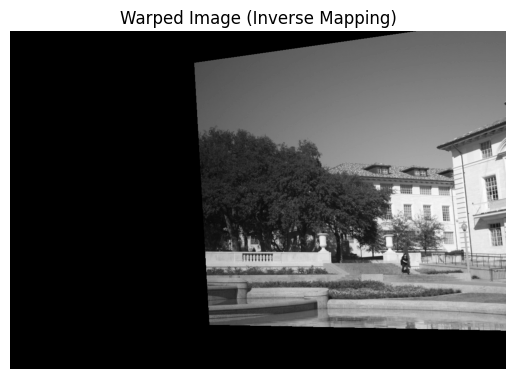

In [35]:
# Get coordinates of good matches
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])


H,_ = compute_homography_ransac(src_pts, dst_pts)

warped_image = warp_image_with_homography(pano_img1, H)
plt.imshow(warped_image, cmap='gray')
plt.title("Warped Image (Inverse Mapping)")
plt.axis('off')
plt.show()

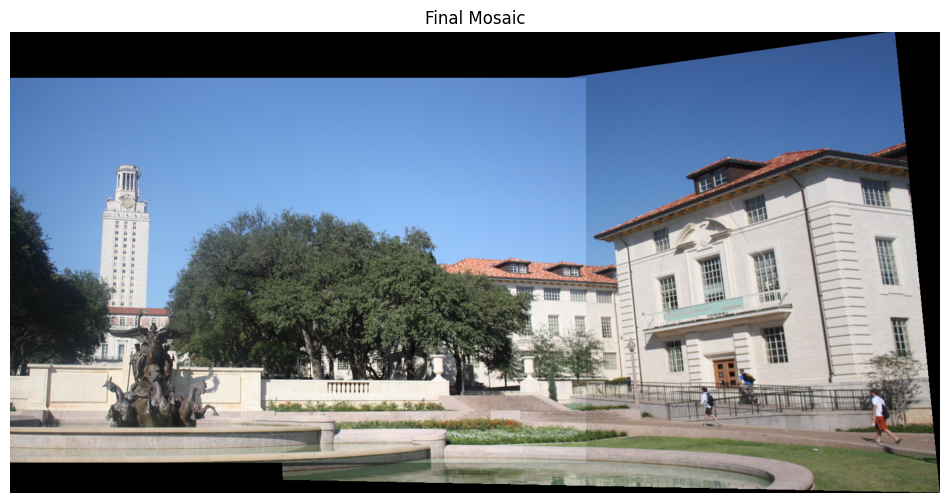

In [36]:
color_img1=cv2.imread('pano_image1.jpg')
color_img2=cv2.imread('pano_image2.jpg')


# mosaic_output = create_image_mosaic(pano_img1, pano_img2, H)
mosaic_output = create_image_mosaic(color_img1, color_img2, H)

def delete_black(image):
    # Deleting black rows
    idy = np.argwhere(np.all(image[..., :] == 0, axis=1))
    image = np.delete(image, idy, axis=0)
    # Deleting black columns
    idx = np.argwhere(np.all(image[..., :] == 0, axis=0))
    image = np.delete(image, idx, axis=1)
    return image

mosaic_output = delete_black(mosaic_output)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(mosaic_output, cv2.COLOR_BGR2RGB) if mosaic_output.ndim == 3 else mosaic_output, cmap='gray')
plt.title("Final Mosaic")
plt.axis("off")
plt.show()


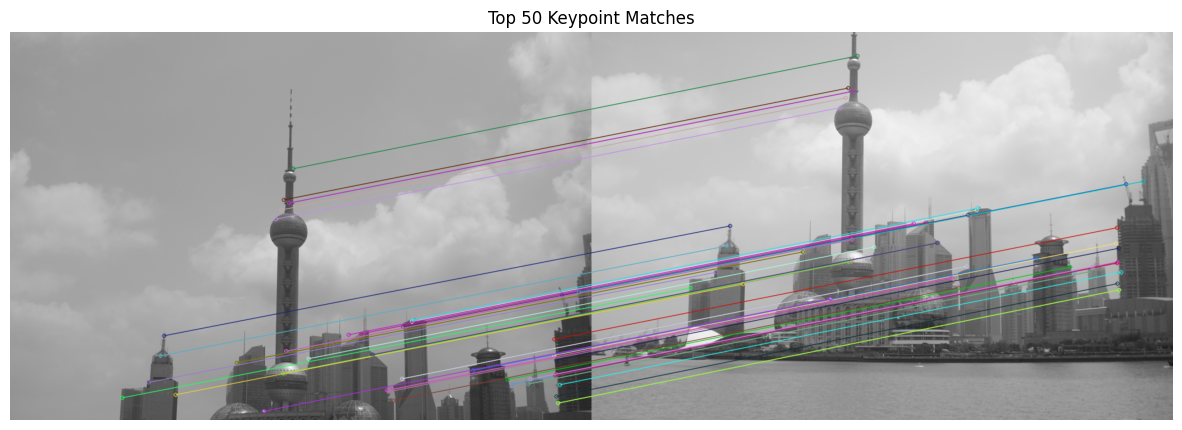

In [37]:
# Load the two images (both should be in grayscale for SIFT)
bonus_img1 = cv2.imread('shanghai-21.png')
bonus_img2 = cv2.imread('shanghai-22.png')

good_matches,keypoints1,keypoints2 = match_keypoints_and_show(bonus_img2, bonus_img1)



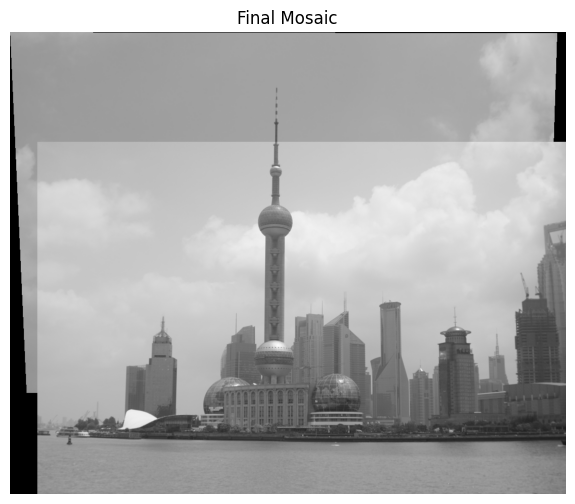

In [38]:
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])


H,_ = compute_homography_ransac(src_pts, dst_pts)

# mosaic_output = create_image_mosaic(pano_img1, pano_img2, H)
mosaic_output = create_image_mosaic(bonus_img2, bonus_img1, H)

def delete_black(image):
    # Deleting black rows
    idy = np.argwhere(np.all(image[..., :] == 0, axis=1))
    image = np.delete(image, idy, axis=0)
    # Deleting black columns
    idx = np.argwhere(np.all(image[..., :] == 0, axis=0))
    image = np.delete(image, idx, axis=1)
    return image

mosaic_output = delete_black(mosaic_output)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(mosaic_output, cv2.COLOR_BGR2RGB) if mosaic_output.ndim == 3 else mosaic_output, cmap='gray')
plt.title("Final Mosaic")
plt.axis("off")
plt.show()


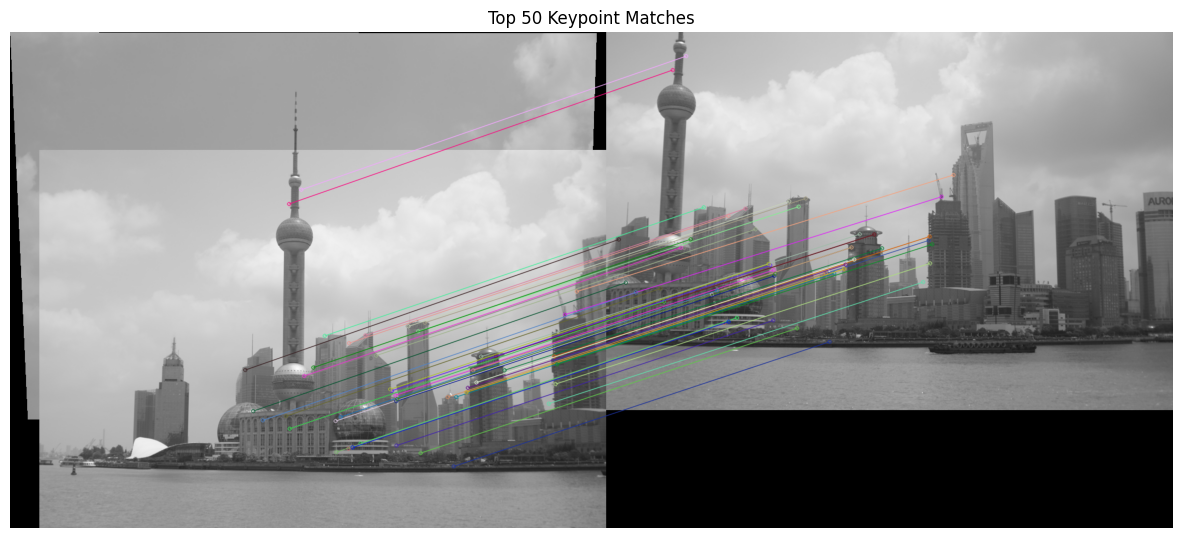

In [39]:
bonus_img3 = cv2.imread('shanghai-23.png')

good_matches,keypoints1,keypoints2 = match_keypoints_and_show(mosaic_output, bonus_img3)



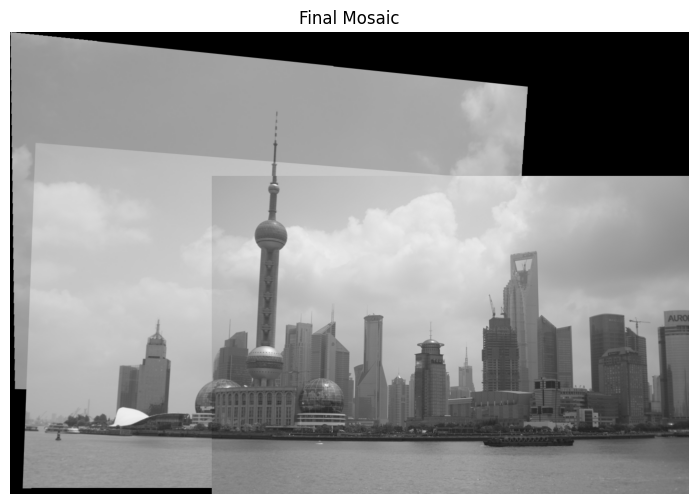

In [40]:
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])


H,_ = compute_homography_ransac(src_pts, dst_pts)

mosaic_output = create_image_mosaic(mosaic_output, bonus_img3, H)

def delete_black(image):
    # Deleting black rows
    idy = np.argwhere(np.all(image[..., :] == 0, axis=1))
    image = np.delete(image, idy, axis=0)
    # Deleting black columns
    idx = np.argwhere(np.all(image[..., :] == 0, axis=0))
    image = np.delete(image, idx, axis=1)
    return image

mosaic_output = delete_black(mosaic_output)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(mosaic_output, cv2.COLOR_BGR2RGB) if mosaic_output.ndim == 3 else mosaic_output, cmap='gray')
plt.title("Final Mosaic")
plt.axis("off")
plt.show()

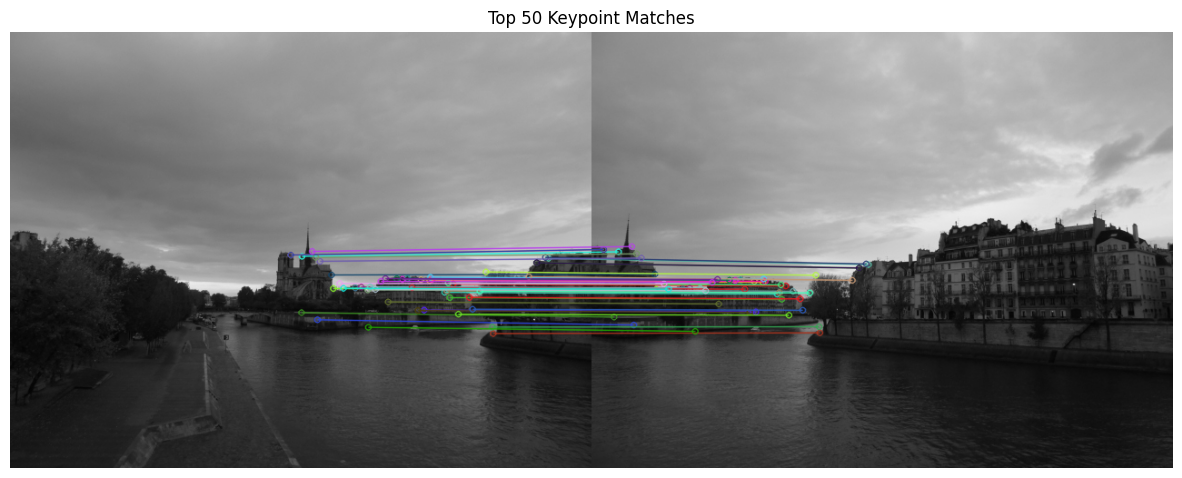

In [41]:
# Load the two images (both should be in grayscale for SIFT)
paris_img1 = cv2.imread("paris_a.jpg",cv2.IMREAD_GRAYSCALE)
paris_img2 = cv2.imread("paris_b.jpg",cv2.IMREAD_GRAYSCALE)

good_matches,keypoints1,keypoints2 = match_keypoints_and_show(paris_img1, paris_img2)

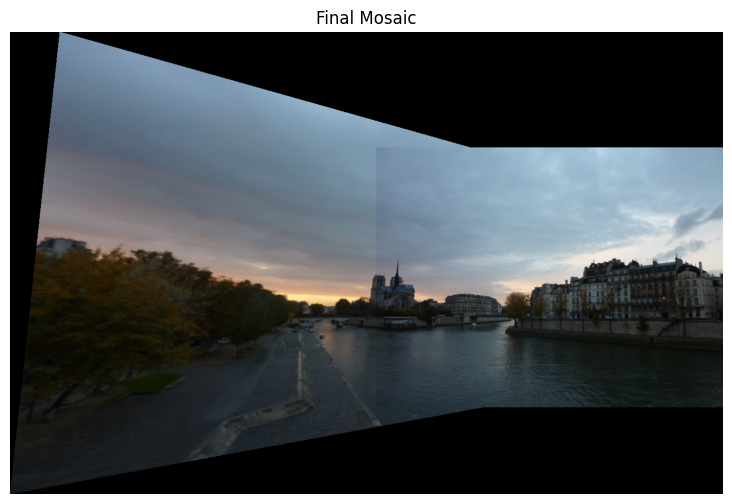

In [42]:
paris_img1 = cv2.imread("paris_a.jpg")
paris_img2 = cv2.imread("paris_b.jpg")
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])


H,_ = compute_homography_ransac(src_pts, dst_pts)

paris_mosaic_output = create_image_mosaic(paris_img1, paris_img2, H)

def delete_black(image):
    # Deleting black rows
    idy = np.argwhere(np.all(image[..., :] == 0, axis=1))
    image = np.delete(image, idy, axis=0)
    # Deleting black columns
    idx = np.argwhere(np.all(image[..., :] == 0, axis=0))
    image = np.delete(image, idx, axis=1)
    return image

paris_mosaic_output = delete_black(paris_mosaic_output)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(paris_mosaic_output, cv2.COLOR_BGR2RGB) if paris_mosaic_output.ndim == 3 else paris_mosaic_output, cmap='gray')
plt.title("Final Mosaic")
plt.axis("off")
plt.show()